In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
exp_df = pd.read_csv('outExp.csv')


In [4]:
exp_df['batch_name'].unique()

array(['Comparable', 'SD', 'LED1', 'LED2', 'LED34', 'LED6'], dtype=object)

In [5]:
# Comparable, SD, LED1, LED2, LED34_odd
exp_df_selected_batches = exp_df[exp_df['batch_name'].isin(['Comparable', 'SD', 'LED1', 'LED2', 'LED34'])]

In [6]:
exp_df_selected_batches_1 = exp_df[
    ((exp_df['batch_name'] == 'LED34') & (exp_df['animal'] % 2 == 1) & (exp_df['session_type'].isin([1,2])))
    | (exp_df['batch_name'] != 'LED34')
]

In [7]:
# LED34 only has odd animal numbers
print(exp_df_selected_batches_1[exp_df_selected_batches_1['batch_name'] == 'LED34']['animal'].unique())
print(exp_df_selected_batches_1[exp_df_selected_batches_1['batch_name'] == 'LED34']['session_type'].unique())

[45 57 59 61 63]
[1. 2.]


In [8]:
# LED_trial = 0 or nan
exp_df_led_off = exp_df_selected_batches_1[\
    exp_df_selected_batches_1['LED_trial'].isna() \
        | (exp_df['LED_trial'] == 0)]

/tmp/ipykernel_25978/3418422298.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exp_df_led_off = exp_df_selected_batches_1[\


In [18]:
exp_df_led_off.loc[:, 'choice'] = 2*(exp_df_led_off['response_poke']) - 5

In [23]:
exp_df_led_off.loc[:, 'accuracy'] = (exp_df_led_off['choice'] * exp_df_led_off['ILD'] > 0).astype(int).copy()

# Helper funcs

In [24]:
def plot_psycho(df):
    ILD_unique = np.sort(df['ILD'].unique())
    prob_choice1 = np.zeros(len(ILD_unique))
    for idx, ild in enumerate(ILD_unique):
        subset = df[df['ILD'] == ild]
        prob = np.mean(subset['choice'] == 1)
        prob_choice1[idx] = prob

    return ILD_unique, prob_choice1


def plot_tacho(df, bins):
    # prob of correct vs RT
    df['RT_bin'] = pd.cut(df['RTwrtStim'], bins=bins, include_lowest=True)
    grouped_by_rt_bin = df.groupby('RT_bin', observed=False)['accuracy'].agg(['mean', 'count'])
    grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
    return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']

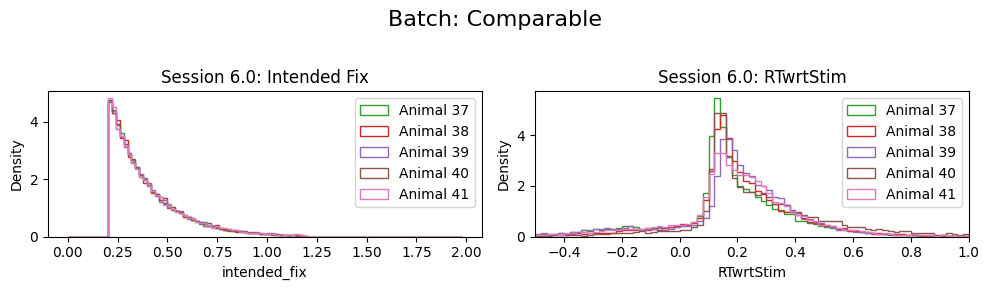

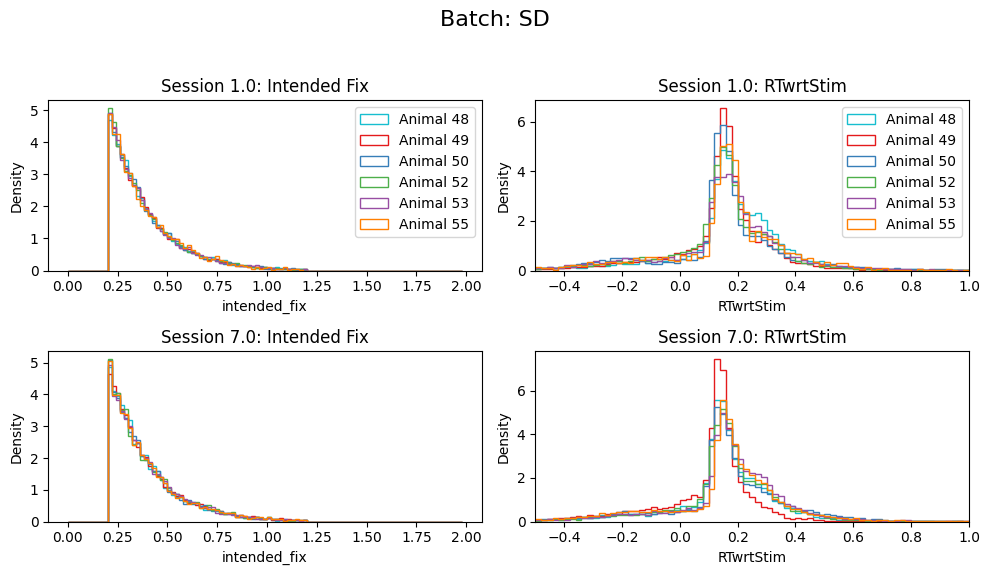

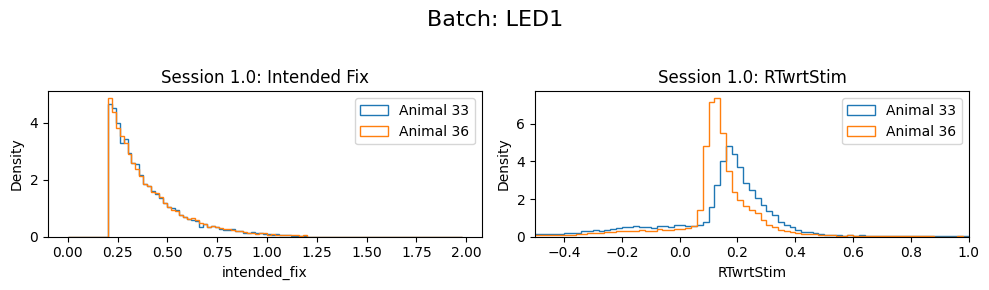

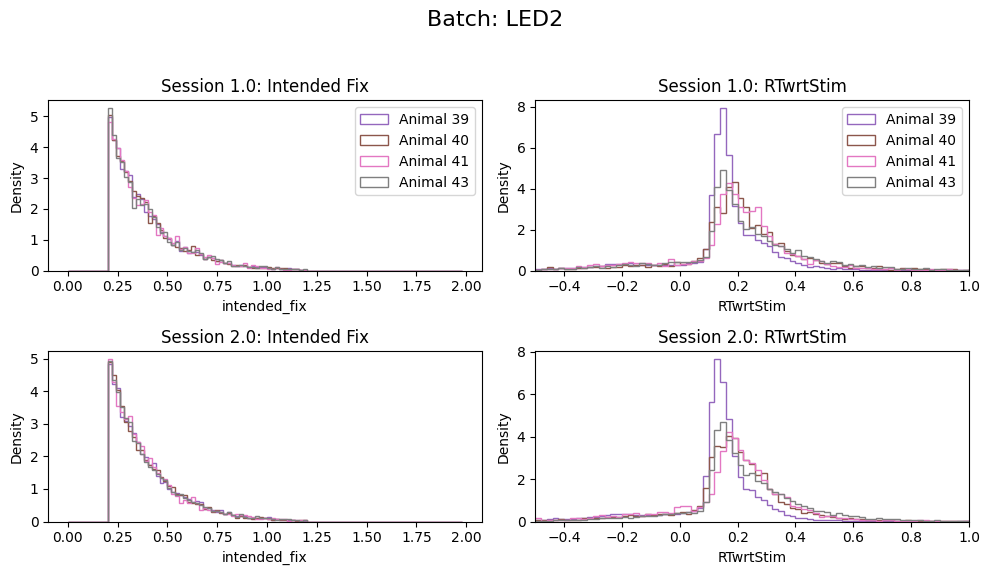

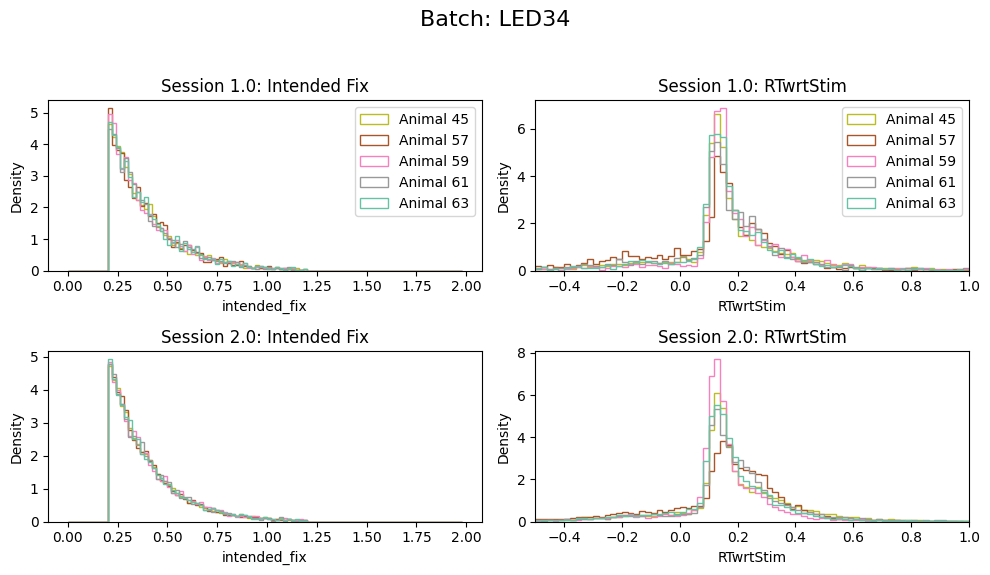

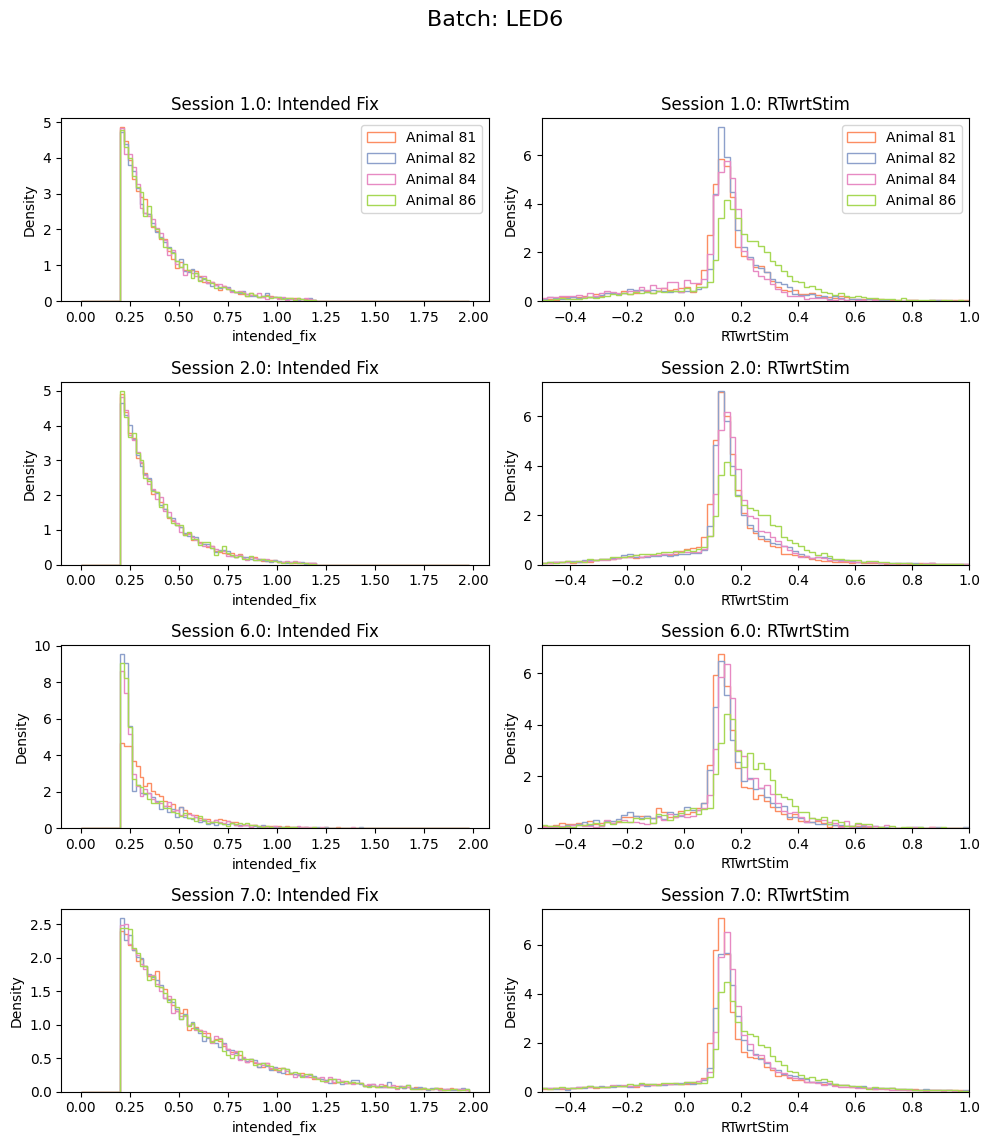

In [8]:
# Define a custom color palette (extend or modify as needed)
custom_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00",
    "#a65628", "#f781bf", "#999999", "#66c2a5", "#fc8d62",
    "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494"
]

all_animals = sorted(exp_df_led_off['animal'].unique())
if len(all_animals) > len(custom_colors):
    raise ValueError("Not enough custom colors for all animals. Please extend the color list.")

animal_to_color = {animal: custom_colors[i] for i, animal in enumerate(all_animals)}

for batch in exp_df_led_off['batch_name'].unique():
    batch_df = exp_df_led_off[exp_df_led_off['batch_name'] == batch]
    session_types = batch_df['session_type'].dropna().unique()
    n_sessions = len(session_types)
    
    fig, axes = plt.subplots(n_sessions, 2, figsize=(10, 3*n_sessions), squeeze=False)
    fig.suptitle(f'Batch: {batch}', fontsize=16)
    
    for i, session in enumerate(session_types):
        session_df = batch_df[batch_df['session_type'] == session]
        ax_fix = axes[i, 0]
        ax_rt = axes[i, 1]
        
        for animal in session_df['animal'].unique():
            animal_df = session_df[session_df['animal'] == animal]
            # Intended Fix
            ax_fix.hist(
                animal_df['intended_fix'].dropna(),
                bins=np.arange(0, 2, 0.02),
                histtype='step',
                color=animal_to_color[animal],
                label=f'Animal {animal}' if i == 0 else None,
                density=True
            )
            # RTwrtStim
            if 'RTwrtStim' in animal_df.columns:
                ax_rt.hist(
                    animal_df['RTwrtStim'].dropna(),
                    bins=np.arange(-1, 2, 0.02),
                    histtype='step',
                    color=animal_to_color[animal],
                    label=f'Animal {animal}' if i == 0 else None,
                    density=True
                )
                ax_rt.set_xlim(-0.5, 1)
        
        ax_fix.set_title(f'Session {session}: Intended Fix')
        ax_fix.set_xlabel('intended_fix')
        ax_fix.set_ylabel('Density')
        ax_rt.set_title(f'Session {session}: RTwrtStim')
        ax_rt.set_xlabel('RTwrtStim')
        ax_rt.set_ylabel('Density')
        if i == 0:
            ax_fix.legend()
            ax_rt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [9]:
from matplotlib.backends.backend_pdf import PdfPages
import os

# Ensure the pdfs directory exists
os.makedirs("pdfs", exist_ok=True)

pdf_path = 'pdfs/all_batches.pdf'
with PdfPages(pdf_path) as pdf:
    for batch in exp_df_led_off['batch_name'].unique():
        batch_df = exp_df_led_off[exp_df_led_off['batch_name'] == batch]
        session_types = batch_df['session_type'].dropna().unique()
        n_sessions = len(session_types)
        
        fig, axes = plt.subplots(n_sessions, 2, figsize=(10, 3*n_sessions), squeeze=False)
        fig.suptitle(f'Batch: {batch}', fontsize=16)
        
        for i, session in enumerate(session_types):
            session_df = batch_df[batch_df['session_type'] == session]
            ax_fix = axes[i, 0]
            ax_rt = axes[i, 1]
            
            for animal in session_df['animal'].unique():
                animal_df = session_df[session_df['animal'] == animal]
                # Intended Fix
                ax_fix.hist(
                    animal_df['intended_fix'].dropna(),
                    bins=np.arange(0, 2, 0.02),
                    histtype='step',
                    color=animal_to_color[animal],
                    label=f'Animal {animal}' if i == 0 else None,
                    density=True
                )
                # RTwrtStim
                if 'RTwrtStim' in animal_df.columns:
                    ax_rt.hist(
                        animal_df['RTwrtStim'].dropna(),
                        bins=np.arange(-1, 2, 0.02),
                        histtype='step',
                        color=animal_to_color[animal],
                        label=f'Animal {animal}' if i == 0 else None,
                        density=True
                    )
                    ax_rt.set_xlim(-0.5, 1)
            
            ax_fix.set_title(f'Session {session}: Intended Fix')
            ax_fix.set_xlabel('intended_fix')
            ax_fix.set_ylabel('Density')
            ax_rt.set_title(f'Session {session}: RTwrtStim')
            ax_rt.set_xlabel('RTwrtStim')
            ax_rt.set_ylabel('Density')
            if i == 0:
                ax_fix.legend()
                ax_rt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)
print(f"Saved all batch figures to {pdf_path}")

Saved all batch figures to pdfs/all_batches.pdf
